In [1]:
from utils import retrieve_transport_plan, shift_and_mix
from visualization_module import  visualize_transport_plan, visualize_transport_distance_distribution, visualize_spectra
from masserstein import Spectrum, NMRSpectrum, dualdeconv4, estimate_proportions
import numpy as np
import pulp

In [2]:
def load_experiment_data(comp_num, data_path, proton_list, delimiter, trim_neg = False, normalize = False):
    how_many_components = comp_num
    spectra = []

    for i in range(how_many_components):
        filename = data_path + '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=delimiter))

    filename = data_path + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=delimiter)
    spectra_objects = []
    names = []
    for i in range(len(spectra)):
        spectra_objects.append(NMRSpectrum(confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])),
                                           protons=proton_list[i]))
        names.append('comp' + str(i))

    mix_spectrum = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
    if trim_neg:
        mix_spectrum.trim_negative_intensities()
        for sp in spectra_objects:
            sp.trim_negative_intensities()
    if normalize:
        mix_spectrum.normalize()
        for sp in spectra_objects:
            sp.normalize()
    return mix_spectrum, spectra_objects, names

In [3]:
components_names = ['Pinene', 'Benzyl benzoate']
proton_list = [16, 12]
comp_num = 2
data_path = "../examples/"
delimiter = ','
kappa_mix = 0.25
kappa_comp = 0.22
interesting_region = (2.15, 2.42)

In [4]:
mix_spectrum, spectra_objects, names = load_experiment_data(comp_num, data_path, proton_list, delimiter)

In [5]:
transport_df, mix_confs, wsom_confs, distances = retrieve_transport_plan(mix=mix_spectrum, spectra=spectra_objects, interesting_region = interesting_region, kappa_components=kappa_comp, kappa_mixture=kappa_mix)

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(np.float64(0.457009), np.float64(9.01304), 0), (np.float64(0.457009), np.float64(9.01304), 1)]
Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(np.float64(0.207009), np.float64(9.26304))]
Ion currents in chunks: [np.float64(0.9999999999999998)]
Deconvolving chunk 0


/home/zofia/Desktop/MASTER_BIOINF/venv/lib/python3.12/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.99728704
Noise proportion in mixture's spectrum: 0.002712969211
Total explanation: 1.000000009211
Noise proportion in combination of components' spectra: 0.0094711537


/home/zofia/bio_project/project/magnetstein/visualization_package/utils.py:172: RuntimeWarning: divide by zero encountered in log10
  distances[kappa_mixture] = -np.log10(noise_in_mix)
/home/zofia/bio_project/project/magnetstein/visualization_package/utils.py:172: RuntimeWarning: invalid value encountered in log10
  distances[kappa_mixture] = -np.log10(noise_in_mix)
/home/zofia/bio_project/project/magnetstein/visualization_package/utils.py:173: RuntimeWarning: divide by zero encountered in log10
  distances[kappa_components] = -np.log10(noise_in_components)
/home/zofia/bio_project/project/magnetstein/visualization_package/utils.py:173: RuntimeWarning: invalid value encountered in log10
  distances[kappa_components] = -np.log10(noise_in_components)


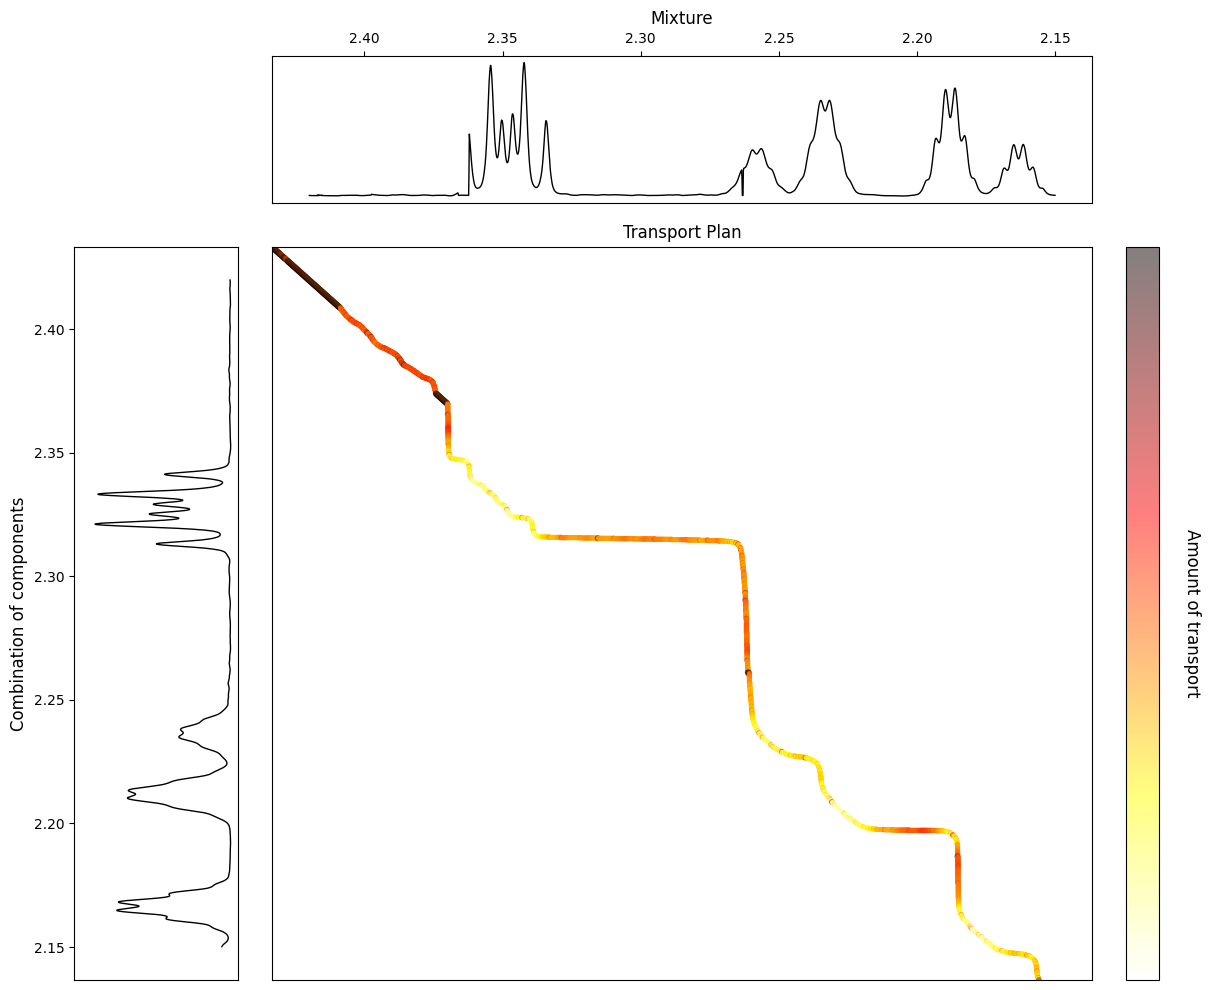

In [6]:
visualize_transport_plan(transport_df, mix_confs, wsom_confs, experiment_name=None, lower_lim=None, upper_lim=None, figures_path=None, variant=None, alpha=0.5)

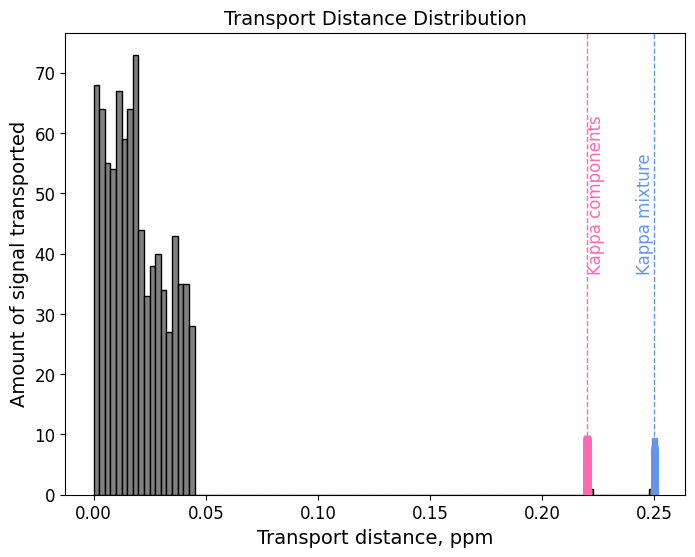

In [7]:
visualize_transport_distance_distribution(distances, kappa_comp, kappa_mix)

In [8]:
mix_spectrum, spectra_objects, names = load_experiment_data(comp_num, data_path, proton_list, delimiter)
kappa_mix = 0.06
kappa_comp = 0.2

In [9]:
estimation_result = dualdeconv4(mix_spectrum, spectra_objects, kappa_mix, kappa_comp, solver = pulp.LpSolverDefault)

probs = estimation_result['probs']
print(probs)

[0.45430685, 0.53548223]


In [10]:
mixed_components2 = shift_and_mix(spectra_objects, [0,0,0,0], probs)
estimation = estimate_proportions(mix_spectrum, [mixed_components2], what_to_compare='area', MTD=kappa_mix, MTD_th=kappa_comp, solver=pulp.LpSolverDefault)

common_horizontal_axis2 = estimation['common_horizontal_axis']

p0 = 1-sum(estimation['proportions'])
p0_prime = estimation['proportion_of_noise_in_components'] 

mix_spectrum.normalize(target_value = 1-p0_prime)
noise_in_mix_spectrum = estimation['noise']
intensities_mix_spectrum = list(np.array([el[1] for el in mix_spectrum.confs]) - np.array(noise_in_mix_spectrum))
mix_spectrum = Spectrum(confs = list(zip(common_horizontal_axis2, intensities_mix_spectrum)))
mix_spectrum.normalize()

for i in range(len(spectra_objects)):
    spectra_objects[i].normalize(target_value = 1-p0)
    noise_in_sp = [probs[i] * noise for noise in estimation["noise_in_components"]]
    intensities_sp = list(np.array([el[1] for el in spectra_objects[i].confs]) - np.array(noise_in_sp))
    spectra_objects[i] = Spectrum(confs = list(zip(common_horizontal_axis2, intensities_sp)))
    spectra_objects[i].normalize()

In [11]:
# you can compute shifts using ConvolutionOptimizer by K.Zakrzewski
shifts = [0.0217096, 0.00428052]

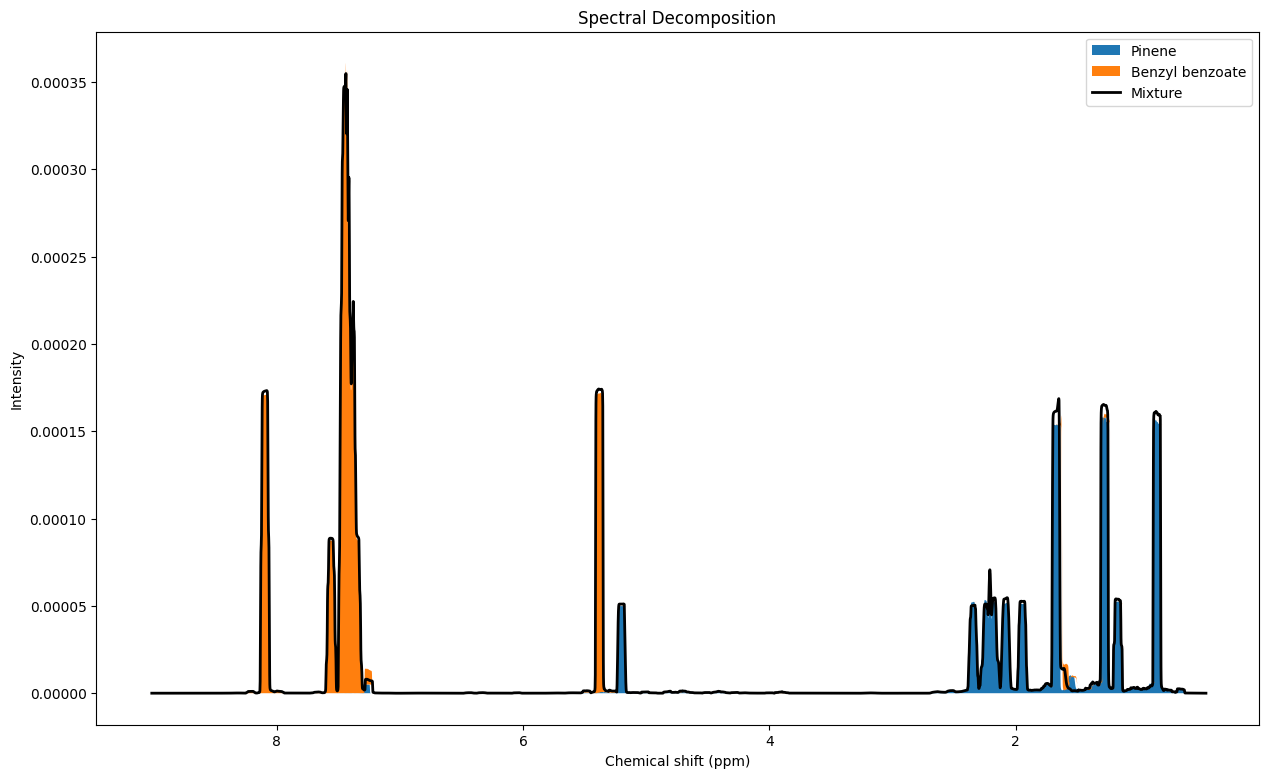

In [12]:
visualize_spectra(mix_spectrum, spectra_objects, probs, components_names, 500, shifts)

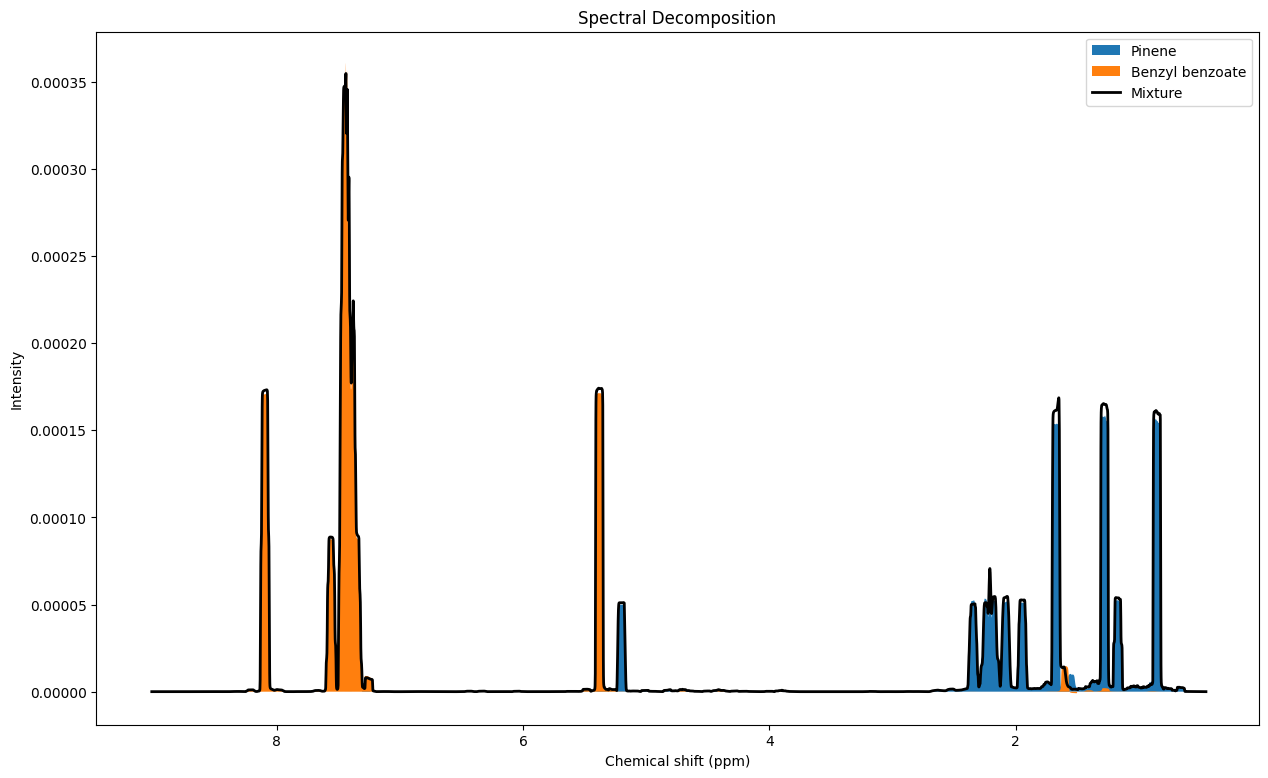

In [13]:
visualize_spectra(mix_spectrum, spectra_objects, probs, components_names, 500, shifts, cumulate=False)